# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

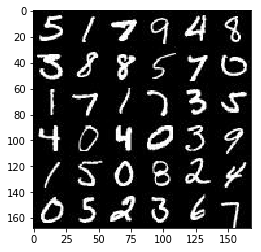

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

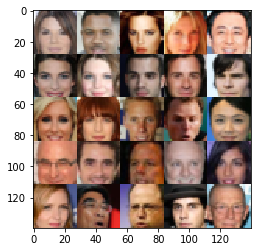

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, \
                        image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate',shape=())
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


# Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images,64,4,strides=2,padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,4,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        
        flatten_out = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flatten_out,1)
        logits = tf.layers.dropout(logits, rate=0.6)

        out = tf.nn.sigmoid(logits)
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        alpha = 0.1
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training = is_train)
        x1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x3,training = is_train)
        x3 = tf.maximum(alpha*x3,x3)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,3,strides=1,padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse = True)     
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1 = beta1).minimize(d_loss,var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1 = beta1).minimize(g_loss,var_list = g_vars)
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,batch_size, input_z, data_shape[3], data_image_mode)

 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3978... Generator Loss: 9.0925
Epoch 1/2... Discriminator Loss: 0.3869... Generator Loss: 8.9403
Epoch 1/2... Discriminator Loss: 0.3763... Generator Loss: 8.3995
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 8.3402
Epoch 1/2... Discriminator Loss: 0.4499... Generator Loss: 7.2110
Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 6.6828
Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 8.9475
Epoch 1/2... Discriminator Loss: 0.3357... Generator Loss: 8.6927
Epoch 1/2... Discriminator Loss: 0.3584... Generator Loss: 8.7774
Epoch 1/2... Discriminator Loss: 0.3762... Generator Loss: 9.0114


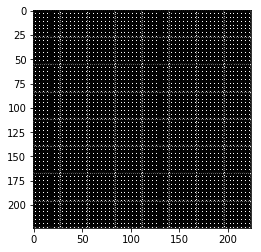

Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 8.4735
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 8.2453
Epoch 1/2... Discriminator Loss: 0.3330... Generator Loss: 9.0503
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 8.3880
Epoch 1/2... Discriminator Loss: 0.3691... Generator Loss: 8.1241
Epoch 1/2... Discriminator Loss: 0.3489... Generator Loss: 5.7313
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 8.0854
Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 5.7021
Epoch 1/2... Discriminator Loss: 0.3529... Generator Loss: 7.2786
Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 8.0501


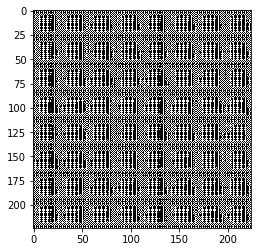

Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 8.9331
Epoch 1/2... Discriminator Loss: 0.3567... Generator Loss: 8.0309
Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 6.8734
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 8.4872
Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 8.7698
Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 9.2405
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 9.1310
Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 9.4392
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 9.7363
Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 9.9529


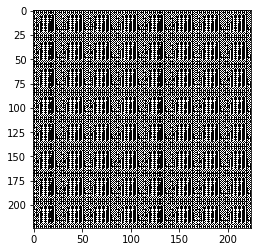

Epoch 1/2... Discriminator Loss: 0.3447... Generator Loss: 8.9582
Epoch 1/2... Discriminator Loss: 0.3400... Generator Loss: 9.0324
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 9.6017
Epoch 1/2... Discriminator Loss: 0.3447... Generator Loss: 9.7144
Epoch 1/2... Discriminator Loss: 0.3288... Generator Loss: 9.1931
Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 9.5418
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 9.2700
Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 5.9864
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 4.4008
Epoch 1/2... Discriminator Loss: 0.5255... Generator Loss: 3.6480


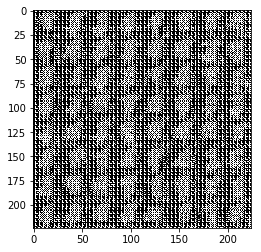

Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 0.4248... Generator Loss: 2.9593
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 4.5576
Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 4.8298
Epoch 1/2... Discriminator Loss: 0.3577... Generator Loss: 4.1387
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 5.4071
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 5.6370
Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 5.7772
Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 5.8733
Epoch 1/2... Discriminator Loss: 0.3354... Generator Loss: 6.1372


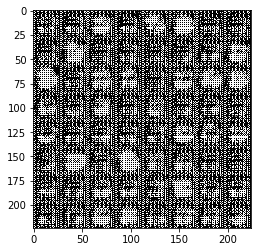

Epoch 1/2... Discriminator Loss: 0.3333... Generator Loss: 6.0286
Epoch 1/2... Discriminator Loss: 0.3297... Generator Loss: 6.6982
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 3.5497
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 2.2862... Generator Loss: 0.2341
Epoch 1/2... Discriminator Loss: 0.4544... Generator Loss: 3.2324
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 2.4286
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 2.9268


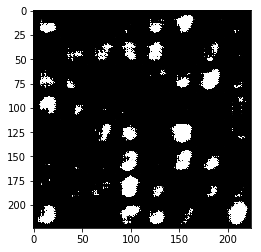

Epoch 1/2... Discriminator Loss: 0.6102... Generator Loss: 1.9127
Epoch 1/2... Discriminator Loss: 5.3004... Generator Loss: 8.7044
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 2.8787
Epoch 1/2... Discriminator Loss: 0.4842... Generator Loss: 2.5360
Epoch 1/2... Discriminator Loss: 4.4596... Generator Loss: 7.1522
Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 3.8562
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 2.4191
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 2.1842
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 4.9828


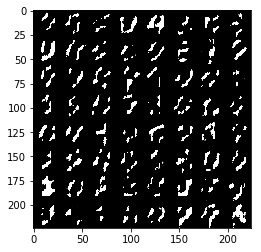

Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.8287
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 5.4437
Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 2.5799
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 3.3466
Epoch 1/2... Discriminator Loss: 1.6697... Generator Loss: 7.4531
Epoch 1/2... Discriminator Loss: 0.5218... Generator Loss: 2.3226
Epoch 1/2... Discriminator Loss: 4.7859... Generator Loss: 9.0328
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 1.1463
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 2.1946
Epoch 1/2... Discriminator Loss: 1.7543... Generator Loss: 0.4334


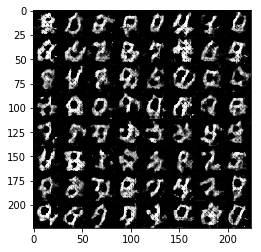

Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 1.5979... Generator Loss: 1.8829
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.5118
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 1.0992


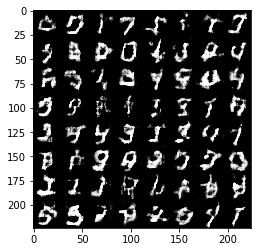

Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 1.5895
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.4950
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 1.4180... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.8377


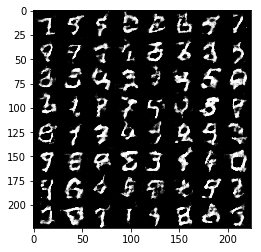

Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.6503
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 2.0325... Generator Loss: 0.2446
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 0.4510
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 1.6195
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 1.2561
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.9851


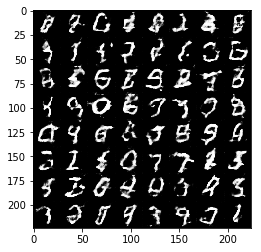

Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 1.6350
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.2421
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 2.0377
Epoch 2/2... Discriminator Loss: 1.3751... Generator Loss: 1.8141
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.9045
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.4075


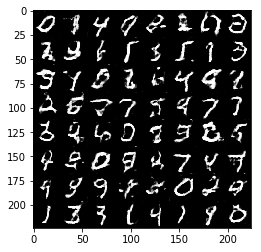

Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 1.3960
Epoch 2/2... Discriminator Loss: 1.2925... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 1.0343
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 2.1217
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 1.5008
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 1.5066


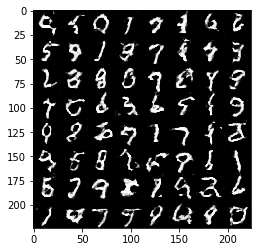

Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 1.7207
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 1.6709... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 1.0853
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 0.8593


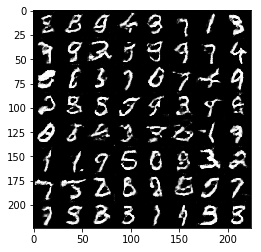

Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 2.1079... Generator Loss: 0.2427
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.4194... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.4308
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 1.1918
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9925


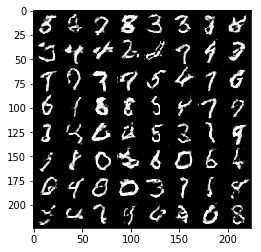

Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.0732
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 1.2634
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.5823... Generator Loss: 0.4353
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 1.0951
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.6089
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.1053... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 1.0815


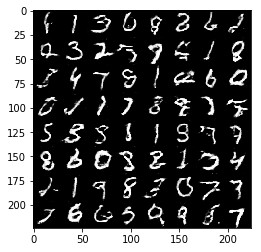

Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.0940
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 1.6450
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 1.1728
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 1.5546
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.4196
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 3.3190


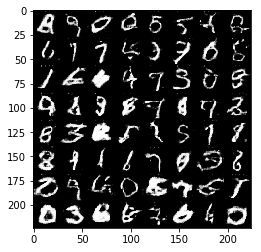

Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 2.0359
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 2.4093
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 2.4074
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 1.7033
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.1329
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 2.0705


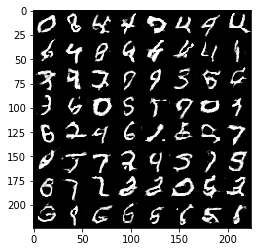

Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 0.8506
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.8779
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.1643
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.7153
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.2035


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.1



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 16.6231
Epoch 1/1... Discriminator Loss: 1.9726... Generator Loss: 2.4232
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 17.9343
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 4.5023
Epoch 1/1... Discriminator Loss: 5.8148... Generator Loss: 15.7791
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 4.3490
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 4.3347
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 5.1326
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 3.1379
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 4.3576


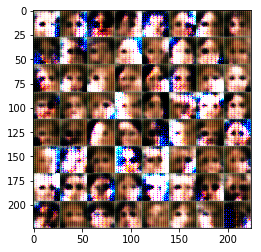

Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.7388... Generator Loss: 2.8104
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 2.9155... Generator Loss: 0.1298
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 2.1922
Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 1.4672
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7554


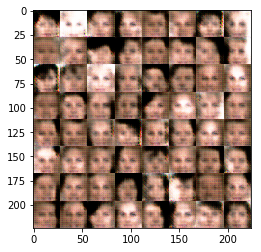

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 1.5120
Epoch 1/1... Discriminator Loss: 1.8710... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.7789... Generator Loss: 2.2592
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.9791... Generator Loss: 0.2282


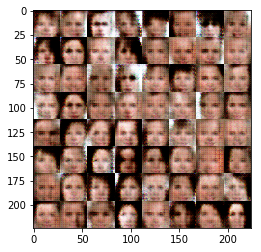

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.8104... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 1.0992


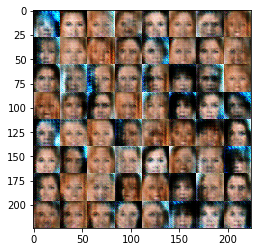

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.3395
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 1.6440


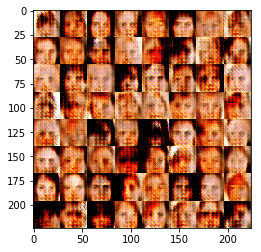

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7857


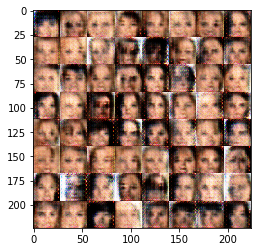

Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7982


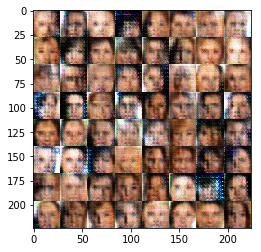

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8055


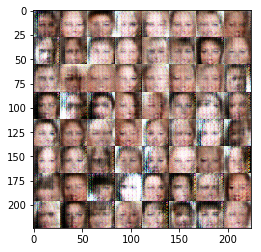

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6508


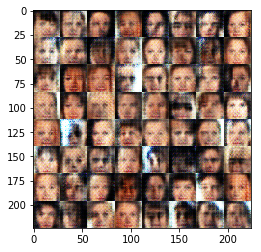

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6743


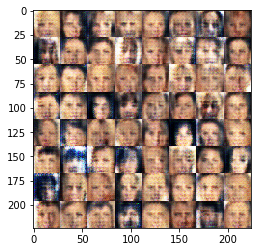

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7453


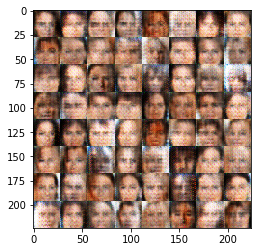

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7942


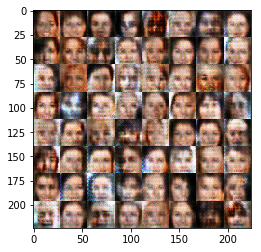

Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7227


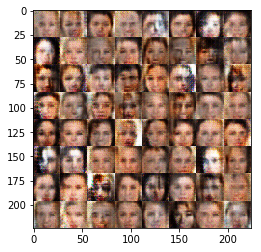

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.9303


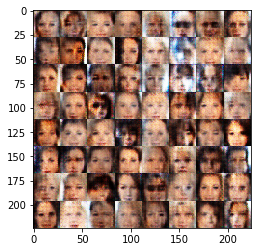

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7649


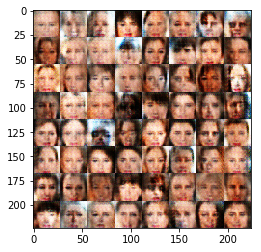

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7337


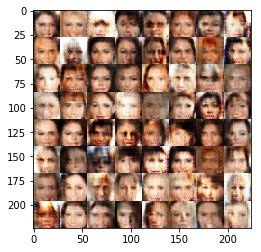

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7578


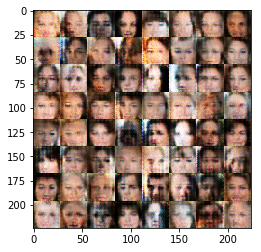

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7153


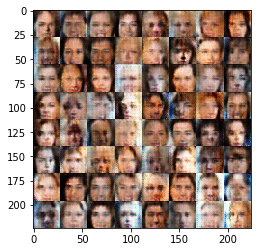

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8437


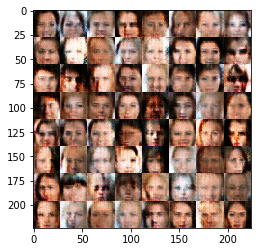

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.9274


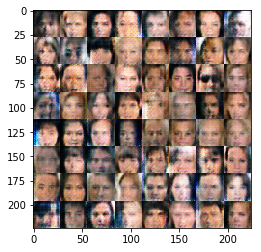

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7585


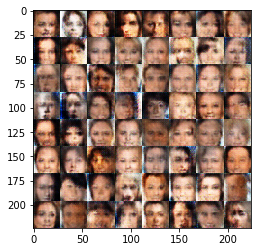

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7520


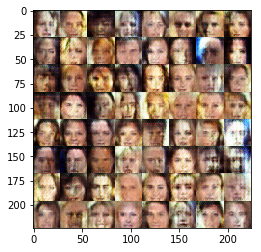

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7726


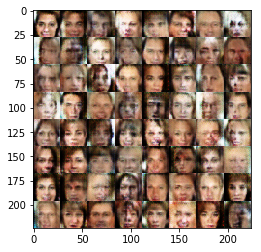

Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8977


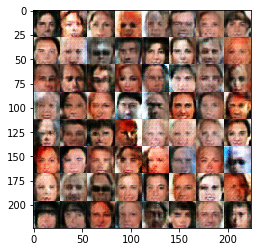

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7604


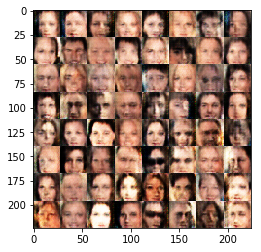

Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.9003


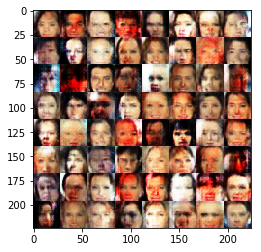

Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7920


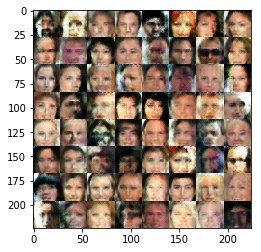

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7342


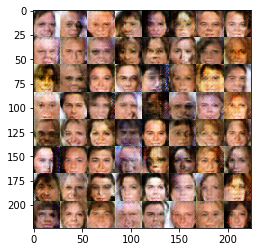

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8115


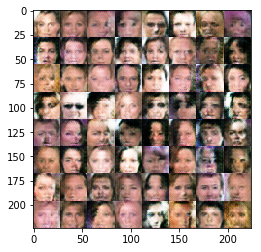

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 5.1782
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 2.2099


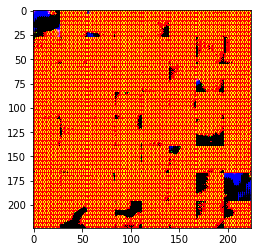

Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 3.9731


KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.